In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [30]:
import import_ipynb
try:
    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\Modules')
except:
    os.chdir('Modules')
from time_shifted_PID import MIfunc
from time_shifted_PID import EqualState
from Spike_Generation import SG
from Spike_Generation import NL

In [31]:
#This function deals with differentiation of angle within [-pi,pi).
#It will fail if angle array x change too fast.
def angular_gradient(x):
    diffx= np.gradient(x)
    diffx[np.abs(diffx)>0.6*np.pi] -= np.pi*diffx[np.abs(diffx)>0.6*np.pi]/abs(diffx[np.abs(diffx)>0.6*np.pi])
    return diffx

# k_E and k_S

In [32]:
def NGD_TK(T, m, n, alpha, beta, g, tau_y):
    dt = np.mean(np.diff(T))
    dt = dt/50
    T = np.arange(0, T[-1]+dt, dt)
    x = T/tau_y /tau_y *np.exp(-T/tau_y)*dt
    y = np.zeros_like(x)
    z = np.zeros_like(x)
    
    for i in range(len(T)):
        y[i] = y[i-1] + dt*(-alpha*y[i-1]+m*x[i-1]-n*z[i-1])
        z[i] = z[i-1] + dt*( -beta*z[i-1]+g*y[i-1])
    return y[:len(T):50], z[:len(T):50]

In [33]:
m = 4.037925
n =	100
alpha = 8.351984
beta = 3.123359
g =  442.699730/n
tau_y = 0.050404
# tau_y = 0.001
# gamma,kappa,K,g=1,0.6,22,10

# m = 22
# n =	22
# alpha = 6
# beta = 1.6
# g =  10
# tau_y = 0.05

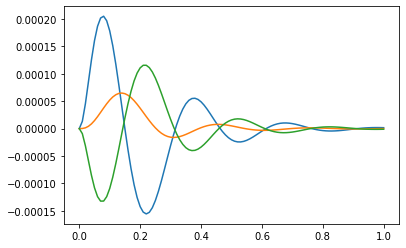

In [34]:
dt = 0.01
TKaxis = np.arange(101)*dt

psi = 0.3
k_E, k_S = NGD_TK(TKaxis, m, n, alpha, beta, g, tau_y)
# y_TK, w_TK = NGD_TK(TKaxis, *[2.67758918, 1.00000000, 1.17089092e+01, 4.69398540, 4.73653606e+02, 2.45547756e-02])
plt.plot(TKaxis, k_E)
plt.plot(TKaxis, k_S)
plt.plot(TKaxis, -(k_E*(1-psi)-k_S*psi))

# LPOU input

In [35]:
tot = 300
Taxis = np.arange(0,tot,dt)
# OU ; input
tau = 1
D = 1
OU=np.zeros(len(Taxis))
mu, sigma = 0, 1
for i in range(len(Taxis)-1):
    OU[i+1]=OU[i]*(1-dt/tau)+np.sqrt(D*dt)*np.random.normal(mu,sigma)
# filtering for OUSmoothed
Fc = 1
b, a = signal.butter(2, 2*Fc*dt, btype='low', analog=False)
LPOU = signal.filtfilt(b, a, OU)
LPOU = (LPOU-np.mean(LPOU))/np.std(LPOU)
x = LPOU

1.222137480469748


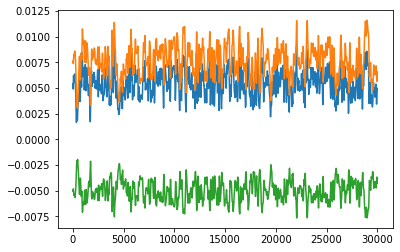

In [90]:
amp = 2
mean = 10

psi = 0.8

apapt_step = int(1/dt)
eOutput = np.convolve( np.hstack((np.ones(apapt_step)*mean,LPOU*amp+mean)), k_E, 'full')[apapt_step:apapt_step+len(LPOU)]
sOutput = np.convolve( np.hstack((np.ones(apapt_step)*mean,LPOU*amp+mean)), k_S, 'full')[apapt_step:apapt_step+len(LPOU)]
baseOutput = eOutput*(1-psi)-sOutput*psi

print(np.std(sOutput)/np.std(eOutput))
plt.plot(eOutput)
plt.plot(sOutput)
plt.plot(baseOutput)


In [91]:
window = [-1,1] # second
timeaxis = np.arange(-100,101)*dt

r = baseOutput
r = NL(r, np.mean(r))
Xcorr = np.correlate(x, r, 'same') / np.correlate(np.ones_like(x), r, 'same')
baseOnXcorr = Xcorr[int(len(Xcorr)/2)-100 : int(len(Xcorr)/2)+101]

r = -baseOutput
r = NL(r, np.mean(r))
Xcorr = np.correlate(x, r, 'same') / np.correlate(np.ones_like(x), r, 'same')
baseOffXcorr = Xcorr[int(len(Xcorr)/2)-100 : int(len(Xcorr)/2)+101]

In [92]:
state_num = 6
xstate = EqualState(LPOU, state_num)[0]

baseOnrstate = SG(baseOutput, dt, 0, 10, 10)
timeshift, baseOnMI = MIfunc(baseOnrstate, xstate, dt, window, perSpike = True)
baseOffrstate = SG(-baseOutput, dt, 0, 10, 10)
timeshift, baseOffMI = MIfunc(baseOffrstate, xstate, dt, window, perSpike = True)

# Subtraction + GC (Gain act on both)

In [93]:
#Gain control function
def gain_func(v):
    try: # if v is an ndarray
        v[v < 0] = 0
    except: # if v is a variable
        if v < 0 : return 1
    return 1/(1+v**4)
    
def AddGainControl(r, B, tau):
    decay = np.exp(-(np.arange(0,1,dt)+dt)/tau)
    # plt.plot(np.arange(0,1,dt)+dt,decay)

    output = np.zeros_like(r)
    gain = np.zeros_like(r)
    for i in np.arange(1,r.shape[0]):
        gain[i] = gain_func(np.sum(B*decay[:min(i,len(decay))]*output[i:max(0, i-len(decay)):-1]*dt) )
        opi = gain[i]*r[i]
        output[i] = opi
    output[output<0] = 0
    return  output, gain

# DCCM

0.05: 0.631; 0.801
0.1: 0.633; 0.802
0.15: 0.636; 0.802
0.2: 0.641; 0.803
0.3: 0.653; 0.804


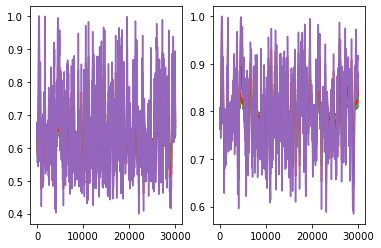

In [94]:
B_e = 3000 #To tune altitude of gain control (D=1/T)
tau_e = 0.1

B_s = 245.0 #To tune altitude of gain control (D=1/T)
tau_s = 0.6

contrast_list = np.array([0.5,1,1.5,2,3])/mean
DCCM_output = [0]*len(contrast_list)
fig, ax = plt.subplots(1,2)
for i in range(len(contrast_list)):
    eOutput = np.convolve( np.hstack((np.ones(apapt_step)*mean,LPOU*contrast_list[i]*mean+mean)), k_E, 'full')[:apapt_step+len(LPOU)]
    sOutput = np.convolve( np.hstack((np.ones(apapt_step)*mean,LPOU*contrast_list[i]*mean+mean)), k_S, 'full')[:apapt_step+len(LPOU)]
    eOutput, gain_e = AddGainControl(eOutput, B_e, tau_e)    
    ax[0].plot(gain_e[apapt_step:])
    sOutput, gain_s = AddGainControl(sOutput, B_s, tau_s)
    ax[1].plot(gain_s[apapt_step:]) # make sure the value of gain is good
    print(str(round(contrast_list[i], 3))+': '+str(round(np.mean(gain_e),3))+'; '+str(round(np.mean(gain_s),3)))
    DCCM_output[i] = -eOutput[apapt_step:]*(1-psi)+sOutput[apapt_step:]*psi
    

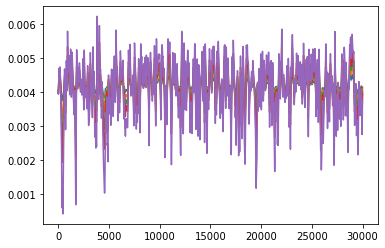

In [95]:
for i in range(len(contrast_list)):
    plt.plot(DCCM_output[i])
# plt.xlim(5000,6000)

(3000.0, 6000.0)

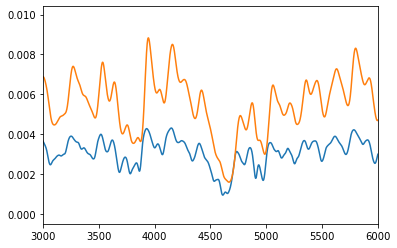

In [96]:
plt.plot(eOutput)
plt.plot(sOutput)
plt.xlim(3000,6000)

### STA

In [97]:
x = np.array(LPOU)
x = (x-np.mean(x))/np.std(x)

DCCM_Xcorr = [0]*len(contrast_list)
for i in range(len(contrast_list)):
    r = DCCM_output[i] 
    r = NL(r, np.mean(r))
    Xcorr = np.correlate(x, r, 'same') / np.correlate(np.ones_like(x), r, 'same')
    Xcorr = Xcorr[int(len(Xcorr)/2)-100 : int(len(Xcorr)/2)+101]
    DCCM_Xcorr[i] = Xcorr.copy()

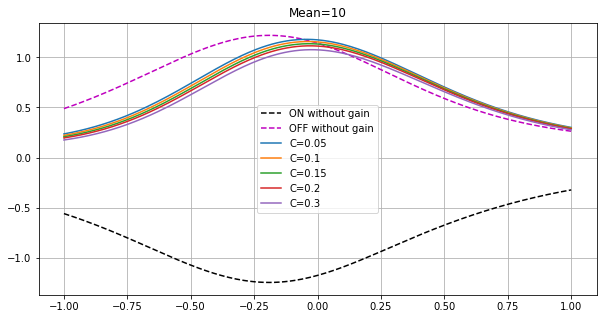

In [98]:
plt.plot(timeaxis,baseOnXcorr, 'k--', label= 'ON without gain')
plt.plot(timeaxis,baseOffXcorr, 'm--',label= 'OFF without gain')
for i in range(len(contrast_list)): 
    plt.plot(timeaxis,DCCM_Xcorr[i], label = 'C='+str(round(contrast_list[i],3)))
plt.legend()
plt.title('Mean='+str(mean))
plt.grid('on')
plt.gcf().set_size_inches(10,5)

### MI

In [99]:
DCCM_rstate = [0]*len(contrast_list)
DCCM_MI = [0]*len(contrast_list)
for i in range(len(contrast_list)):
    # rstate, _ = np.histogram( Spike_Time_Generater(DCCM_output[i], dt, 10, 10), np.append(Taxis, tot))
    rstate =SG(DCCM_output[i], dt, 0, 10, 10)
    DCCM_rstate[i] = rstate.copy()
    timeshift, DCCM_MI[i] = MIfunc(rstate, xstate, dt, window, perSpike = True)

In [100]:
for rstate in DCCM_rstate:
    print(np.var(rstate), np.mean(rstate))

0.08974634555555554 0.09943333333333333
0.09041326222222221 0.10026666666666667
0.09038661222222225 0.10023333333333333
0.0902666388888889 0.10016666666666667
0.09011999555555557 0.10006666666666666


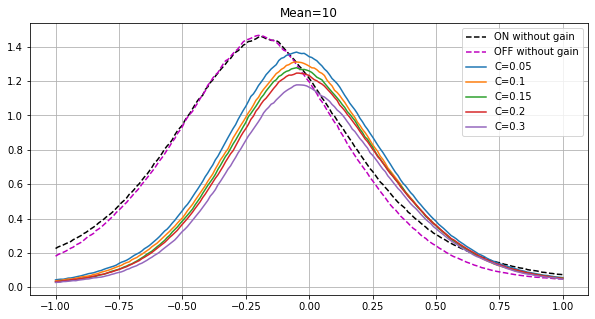

In [108]:
plt.plot(timeaxis,baseOnMI, 'k--', label= 'ON without gain')
plt.plot(timeaxis,baseOffMI, 'm--', label= 'OFF without gain')
for i in range(len(contrast_list)): 
    plt.plot(timeshift,DCCM_MI[i], label = 'C='+str(round(contrast_list[i],3)))
plt.legend()
plt.title('Mean='+str(mean))
plt.grid('on')
plt.gcf().set_size_inches(10,5)

## LPOU (low contrast) + WN

0.636; 0.802
0.491; 0.651


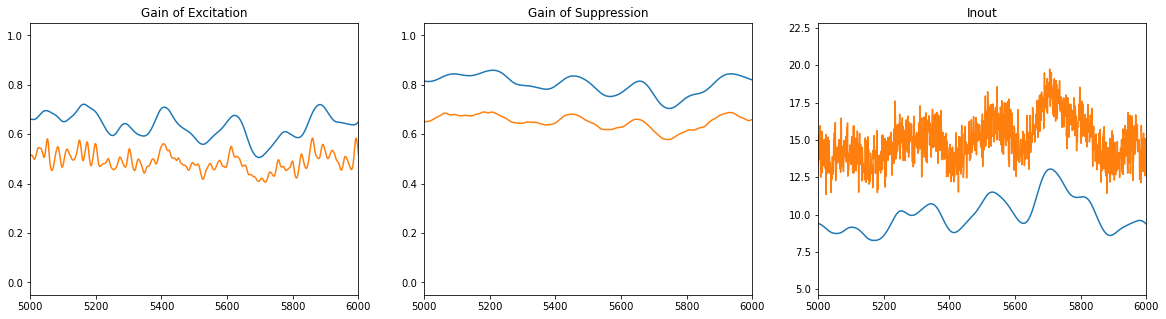

In [102]:
lowContrastLPOU = (x*contrast_list[2]*mean+mean)
WN = np.random.normal(5,1, size=len(x))

fig, ax = plt.subplots(1,3)
ax[2].plot(lowContrastLPOU, zorder = 1)
ax[2].plot(lowContrastLPOU+WN, zorder = 0)


eOutput = np.convolve( lowContrastLPOU, k_E, 'full')[:len(x)]
sOutput = np.convolve( lowContrastLPOU, k_S, 'full')[:len(x)]
eOutput, gain_e = AddGainControl(eOutput, B_e, tau_e)    
ax[0].plot(gain_e, zorder = 1)
sOutput, gain_s = AddGainControl(sOutput, B_s, tau_s)
ax[1].plot(gain_s, zorder = 1) # make sure the value of gain is good
print(str(round(np.mean(gain_e),3))+'; '+str(round(np.mean(gain_s),3)))

eOutput = np.convolve( lowContrastLPOU+WN, k_E, 'full')[:len(x)]
sOutput = np.convolve( lowContrastLPOU+WN, k_S, 'full')[:len(x)]
eOutput, gain_e = AddGainControl(eOutput, B_e, tau_e)    
ax[0].plot(gain_e, zorder = 0)
sOutput, gain_s = AddGainControl(sOutput, B_s, tau_s)
ax[1].plot(gain_s, zorder = 0) # make sure the value of gain is good
print(str(round(np.mean(gain_e),3))+'; '+str(round(np.mean(gain_s),3)))

for axi in ax:
    axi.set_xlim(5000,6000)
ax[0].set_title('Gain of Excitation')
ax[1].set_title('Gain of Suppression')
ax[2].set_title('Inout')
fig.set_size_inches(20,5)

LPOUaddWN_output = -eOutput*(1-psi)+sOutput*psi

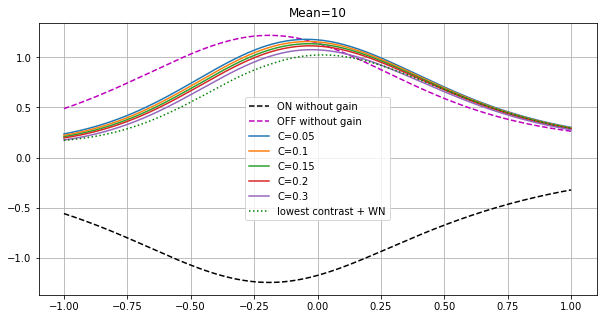

In [103]:
r = LPOUaddWN_output
r = NL(r, np.mean(r))
Xcorr = np.correlate(x, r, 'same') / np.correlate(np.ones_like(x), r, 'same')
LPOUaddWN_Xcorr = Xcorr[int(len(Xcorr)/2)-100 : int(len(Xcorr)/2)+101]

plt.plot(timeaxis,baseOnXcorr, 'k--', label= 'ON without gain')
plt.plot(timeaxis,baseOffXcorr, 'm--',label= 'OFF without gain')
for i in range(len(contrast_list)): 
    plt.plot(timeaxis,DCCM_Xcorr[i], label = 'C='+str(round(contrast_list[i],3)))
plt.plot(timeaxis,LPOUaddWN_Xcorr, 'g:',label = 'lowest contrast + WN') 
plt.legend()
plt.title('Mean='+str(mean))
plt.grid('on')
plt.gcf().set_size_inches(10,5)

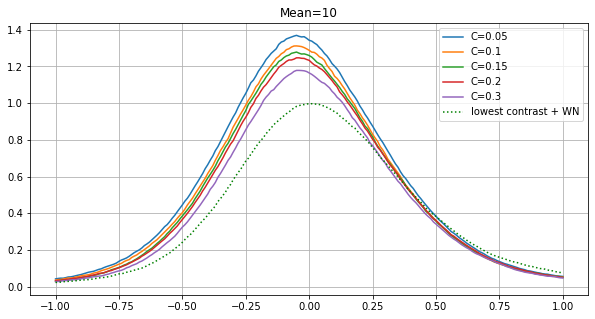

In [104]:
rstate = SG(LPOUaddWN_output, dt, 0, 10, 10)
timeshift, LPOUaddWN_MI = MIfunc(rstate, xstate, dt, window, perSpike = True)
# plt.plot(timeaxis,baseOnMI, 'k--', label= 'ON without gain')
# plt.plot(timeaxis,baseOffMI, 'm--', label= 'OFF without gain')
for i in range(len(contrast_list)): 
    plt.plot(timeshift,DCCM_MI[i], label = 'C='+str(round(contrast_list[i],3)))
plt.plot(timeaxis,LPOUaddWN_MI, 'g:',label = 'lowest contrast + WN') 
plt.plot()
plt.legend()
plt.title('Mean='+str(mean))
plt.grid('on')
plt.gcf().set_size_inches(10,5)

# White Noise STA

0.05: 0.63; 0.801
0.1: 0.632; 0.801
0.15: 0.635; 0.801
0.2: 0.638; 0.801
0.3: 0.647; 0.801


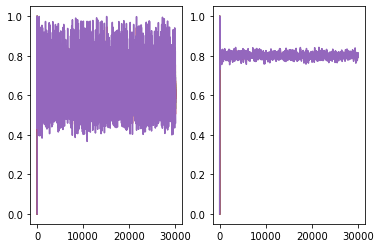

In [105]:
WN = np.random.normal(0,1, size=len(x))

DCCM_WNoutput = [0]*len(contrast_list)
fig, ax = plt.subplots(1,2)
for i in range(len(contrast_list)):
    eOutput = np.convolve( (WN*contrast_list[i]*mean+mean), k_E, 'full')[:len(WN)]
    sOutput = np.convolve( (WN*contrast_list[i]*mean+mean), k_S, 'full')[:len(WN)]
    eOutput, gain_e = AddGainControl(eOutput, B_e, tau_e)    
    ax[0].plot(gain_e)
    sOutput, gain_s = AddGainControl(sOutput, B_s, tau_s)
    ax[1].plot(gain_s) # make sure the value of gain is good
    print(str(round(contrast_list[i], 3))+': '+str(round(np.mean(gain_e),3))+'; '+str(round(np.mean(gain_s),3)))
    DCCM_WNoutput[i] = -eOutput*(1-psi)+sOutput*psi

In [106]:
DCCM_WNXcorr = [0]*len(contrast_list)
for i in range(len(contrast_list)):
    r = DCCM_WNoutput[i] 
    r = NL(r, np.mean(r))
    Xcorr = np.correlate(WN, r, 'same') / np.correlate(np.ones_like(x), r, 'same')
    Xcorr = Xcorr[int(len(Xcorr)/2)-100 : int(len(Xcorr)/2)+101]
    DCCM_WNXcorr[i] = Xcorr.copy()

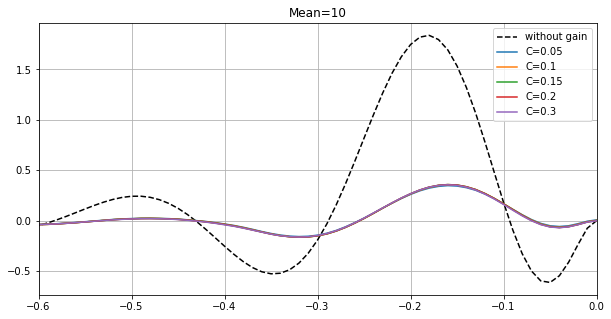

In [107]:
plt.plot(-TKaxis, -(k_E*(1-psi)-k_S*psi)*30000, 'k--', label= 'without gain')
for i in range(len(contrast_list)):
    plt.plot(timeaxis,DCCM_WNXcorr[i], label = 'C='+str(round(contrast_list[i],3)))
plt.legend()
plt.title('Mean='+str(mean))
plt.xlim(-0.6,0)
plt.grid('on')
plt.gcf().set_size_inches(10,5)